In [1]:
import config
from preprocessing import mappings, transforms, treebank_reader
from training import pcfg, lpcfg

if __name__ == '__main__':
    config.train = treebank_reader.read(config.train_file)

    config.nonterminal_map = mappings.NonterminalMap(config.train)

Nonterminal mappings: 100%|██████████| 39832/39832 [00:02<00:00, 19545.73it/s]


In [2]:
from collections import Counter

In [3]:
cnt = Counter()
for tree in config.train:
    for node in tree.postorder():
        cnt[node.label()] += 1

In [6]:
cnt.most_common()[::-1]

[('ADJP+ADVP', 1),
 ('WHADVP+DT', 1),
 ('ADVP+NNS', 1),
 ('RRC+VP', 1),
 ('UCP+PP', 1),
 ('QP+PDT', 1),
 ('ADVP+VBN', 1),
 ('SBAR+RB', 1),
 ('NAC+NNS', 1),
 ('X+MD', 1),
 ('SBAR+S+VP+VBN', 1),
 ('QP+NNS', 1),
 ('VP+ADVP+IN', 1),
 ('NX+S', 1),
 ('FRAG+RB', 1),
 ('NX+S+VP', 1),
 ('NP+PRN', 1),
 ('WHNP+WRB', 1),
 ('X+SBARQ', 1),
 ('SBAR+WHADVP+WRB', 1),
 ('NP+S', 1),
 ('NP+FRAG', 1),
 ('WHNP+NN', 1),
 ('PRT+VBP', 1),
 ('SBAR+WHNP+WDT', 1),
 ('NX+CD', 1),
 ('NP+WRB', 1),
 ('QP+DT', 1),
 ('FRAG+ADJP+DT', 1),
 ('ADVP+VBD', 1),
 ('INTJ+JJ', 1),
 ('ADJP+NP', 1),
 ('INTJ+S', 1),
 ('NP+TO', 1),
 ('QP+RB', 1),
 ('FRAG+S+ADJP+JJ', 1),
 ('PRN+FRAG+WHADJP', 1),
 ('QP+RBR', 1),
 ('WHADVP+WDT', 1),
 ('S+ADVP+RBR', 1),
 ('UCP+ADJP', 1),
 ('S+ADVP+NN', 1),
 ('S+VP+MD', 1),
 ('WHNP+VBP', 1),
 ('ADVP+PRT+RP', 1),
 ('SBARQ+WHADVP+WRB', 1),
 ('PRT+RBR', 1),
 ('SBAR+SBARQ', 1),
 ('PRT|ADVP+NN', 1),
 ('NP+ADVP+DT', 1),
 ('EX', 1),
 ('NX+VBZ', 1),
 ('WHADVP+RB', 1),
 ('FRAG+UCP', 1),
 ('PRN+NP', 1),
 ('FRAG+WH

In [24]:
cut = set()
for nt, c in cnt.most_common()[::-1]:
    if c < 10:
        cut.add(nt)
    else:
        break

In [25]:
len(cut)

182

In [16]:
new_train = []
for tree in config.train:
    add = True
    for node in tree.postorder():
        if node.label() in cut:
            add = False
    if add:
        new_train.append(tree)

In [17]:
len(config.train)

39832

In [18]:
len(new_train)

39343

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import config
from preprocessing import mappings, transforms, treebank_reader
from training import parameter, rules, rules_and_count

tb = treebank_reader.TreebankReader(config.train_file)
config.train = tb.read()

config.nonterminal_map = mappings.NonterminalMap(config.train)
config.terminal_map = mappings.TerminalMap(config.train, len(config.nonterminal_map))
transforms.transform_trees()

15:30:20 - TreebankReader starts reading file.
100%|██████████| 842/842 [00:00<00:00, 1346.70it/s]
15:30:21 - TreebankReader finishes reading file.
15:30:21 - Creating mappings between non-terminals and ints.
nonterminal_map: 100%|██████████| 842/842 [00:00<00:00, 23927.99it/s]
15:30:21 - Finished creating mappings.
15:30:21 - Creating mappings between terminals and ints.
100%|██████████| 9/9 [00:00<00:00, 272.27it/s]
15:30:21 - Finished creating mappings.
15:30:21 - Transforming str/int trees to int/str trees.
100%|██████████| 842/842 [00:00<00:00, 5101.64it/s]
15:30:21 - Finished transforming trees.


In [4]:
from collections import Counter, defaultdict
import numpy as np
import scipy as sp
from tqdm import tqdm

In [5]:
c = Counter()
for tree in config.train:
    for node in tree.postorder():
        c[node.label()] += 1

In [6]:
d = len(config.nonterminal_map)

In [161]:
fi = defaultdict(list)
fo = defaultdict(list)

In [162]:
for tree in tqdm(config.train):
    for node in tree.postorder():
        x = np.zeros(6*d, dtype=np.float32)
        
        if len(node) == 2:
            l, r = node[0], node[1]
            x[0*d + l.label()] = 10
            x[1*d + r.label()] = 10
            if len(l) == 2:
                ll, lr = l[0], l[1]
                x[2*d + ll.label()] = 10
                x[3*d + lr.label()] = 10
            if len(r) == 2:
                rl, rr = r[0], r[1]
                x[4*d + rl.label()] = 10
                x[5*d + rr.label()] = 10
                
        y = np.zeros(6*d, dtype=np.float32)
        cur, parent = node, node.parent()
        i = 0
        while i < 2 and parent is not None:
            k = 3*i
            y[k*d + parent.label()] = 10
            if cur is parent[0]:
                y[(k+2)*d + parent[1].label()] = 10
            else:
                y[(k+1)*d + parent[0].label()] = 10
            i += 1
            cur, parent = parent, parent.parent()
        
        fi[node.label()].append(sp.sparse.csr_matrix(x))
        fo[node.label()].append(sp.sparse.csr_matrix(y))

100%|██████████| 842/842 [00:17<00:00, 48.43it/s]


In [163]:
for k, v in fi.items():
    fi[k] = sp.sparse.vstack(v)
for k, v in fo.items():
    fo[k] = sp.sparse.vstack(v)

In [164]:
from sklearn.cluster import MiniBatchKMeans

In [174]:
km = MiniBatchKMeans(n_clusters=8)

In [180]:
Counter(km.fit_predict(fi[0]))

Counter({1: 325, 2: 313, 7: 88, 0: 21, 6: 357, 3: 125, 5: 97, 4: 82})

In [181]:
Counter(km.fit_predict(fo[0]))

Counter({0: 854, 7: 65, 4: 38, 2: 149, 5: 155, 1: 45, 3: 87, 6: 15})

In [182]:
km.fit_predict(fi[0])

array([1, 3, 7, ..., 1, 7, 4], dtype=int32)

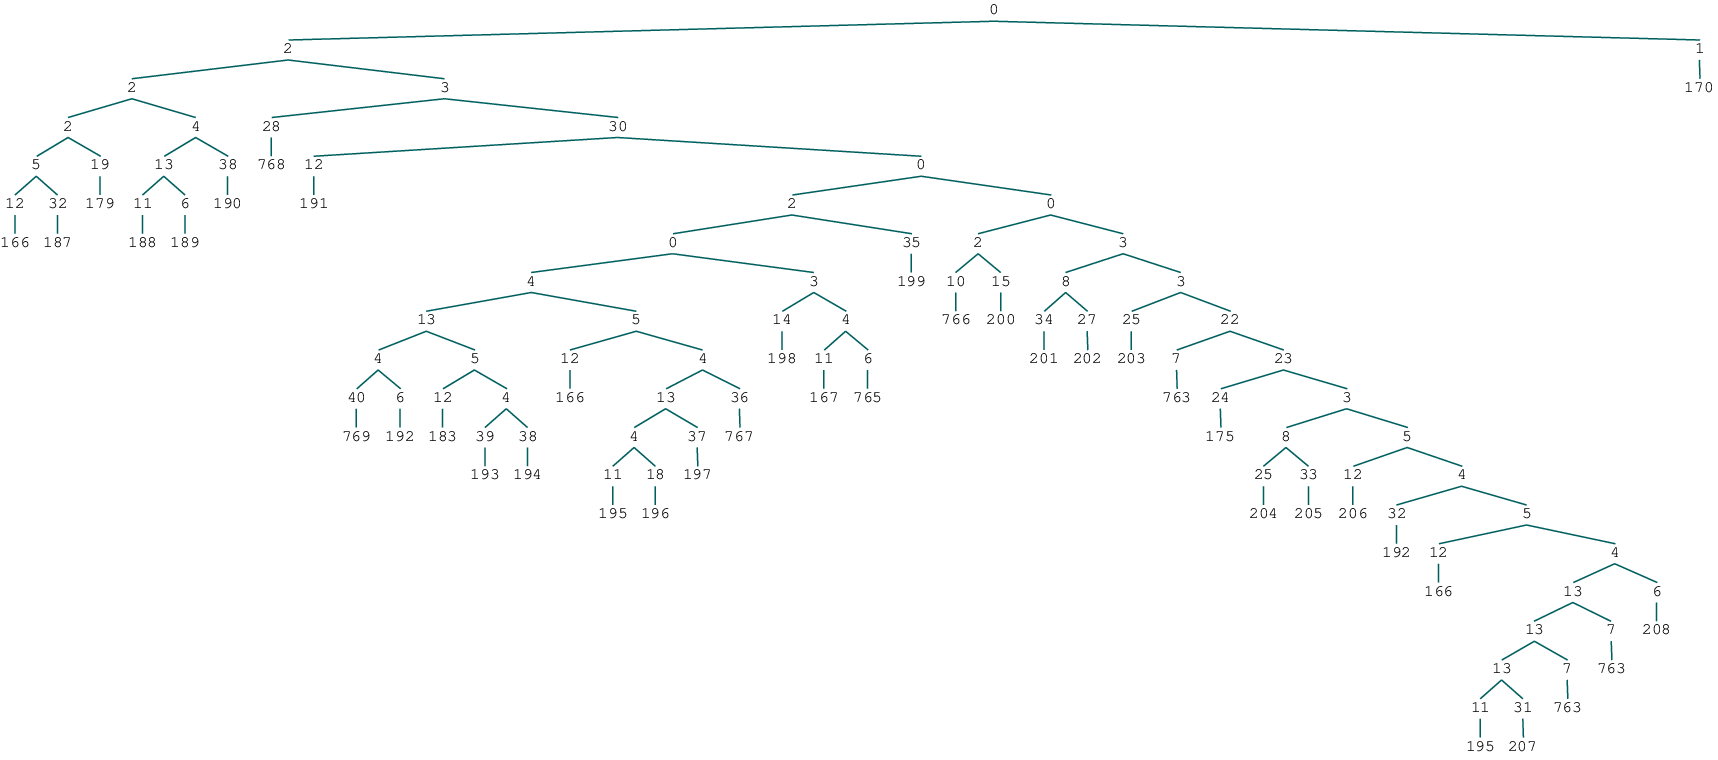

In [185]:
config.train[2]